# Лаборатная работа 3
**Выполнила:** Сидельникова Дарья

Библиотеки

In [ ]:
pip install kneed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.stats import zscore
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

Работа с данными

In [ ]:
df = pd.read_csv('Lab3.csv')
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


name - название страны

child_mort - cмертность детей в возрасте до 5 лет на 1000 живорождений

exports - экспорт товаров и услуг на душу населения. Приведено в % от ВВП на душу населения

health - общие расходы на здравоохранение на душу населения. Указаны как % от ВВП на душу населения

Imports - импорт товаров и услуг на душу населения. Указано в % от ВВП на душу населения.

Income - чистый доход на человека

Inflation - измерение годового темпа роста общего ВВП

life_expec - ожидаемая продолжительность жизни

total_fer - ожидаемая рождаемость

gdpp - ВВП на душу населения


Анализируем данные

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


Проверяем пропуски

In [ ]:
for col in df.columns:
    pct_missing = df[col].isnull().mean()
    print('{} - {}%'.format(col, round(pct_missing*100)))

country - 0%
child_mort - 0%
exports - 0%
health - 0%
imports - 0%
income - 0%
inflation - 0%
life_expec - 0%
total_fer - 0%
gdpp - 0%


Описательная статистика

In [ ]:
df. describe( include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,167,167,Afghanistan,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
child_mort,167.0,NaN,NaN,NaN,38.27006,40.328931,2.6,8.25,19.3,62.1,208.0
exports,167.0,NaN,NaN,NaN,41.108976,27.41201,0.109,23.8,35.0,51.35,200.0
health,167.0,NaN,NaN,NaN,6.815689,2.746837,1.81,4.92,6.32,8.6,17.9
imports,167.0,NaN,NaN,NaN,46.890215,24.209589,0.0659,30.2,43.3,58.75,174.0
income,167.0,NaN,NaN,NaN,17144.688623,19278.067698,609.0,3355.0,9960.0,22800.0,125000.0
inflation,167.0,NaN,NaN,NaN,7.781832,10.570704,-4.21,1.81,5.39,10.75,104.0
life_expec,167.0,NaN,NaN,NaN,70.555689,8.893172,32.1,65.3,73.1,76.8,82.8
total_fer,167.0,NaN,NaN,NaN,2.947964,1.513848,1.15,1.795,2.41,3.88,7.49
gdpp,167.0,NaN,NaN,NaN,12964.155689,18328.704809,231.0,1330.0,4660.0,14050.0,105000.0


Сперва заменим инфляцию, которая не может быть отрицательной, поэтому заменю на 1.8, что близко к стандартной (2%)




In [ ]:
salary_q25 = df['inflation'].quantile(0.25)
df['inflation'] = np.where(df['inflation'] < 2, salary_q25, df['inflation'])

Находим нижнюю границу 10% - для белных стран и 90% вернюю для богатых стран

In [ ]:
df = df.rename(columns=str.lower)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

skip_cols = {'inflation'}
cols_to_wins = [c for c in num_cols if c not in skip_cols]

def winsorize_series(s, p_low=0.10, p_high=0.90):
    lo, hi = s.quantile([p_low, p_high])
    return s.clip(lower=lo, upper=hi)


df_w = df.copy()
for c in cols_to_wins:
    df_w[c] = winsorize_series(df_w[c], 0.10, 0.90)

before = df[num_cols].describe(percentiles=[.10,.5,.90]).T[['min','10%','50%','90%','max']]
after  = df_w[num_cols].describe(percentiles=[.10,.5,.90]).T[['min','10%','50%','90%','max']]
display(before.head(10))
display(after.head(10))

,min,10%,50%,90%,max
child_mort,2.6000,4.200,19.30,100.220,208.00
exports,0.1090,15.660,35.00,70.800,200.00
health,1.8100,3.726,6.32,10.940,17.90
imports,0.0659,22.520,43.30,75.420,174.00
income,609.0000,1524.000,9960.00,41220.000,125000.00
inflation,1.8100,1.810,5.39,16.640,104.00
life_expec,32.1000,57.820,73.10,80.400,82.80
total_fer,1.1500,1.452,2.41,5.322,7.49
gdpp,231.0000,593.800,4660.00,41840.000,105000.00


,min,10%,50%,90%,max
child_mort,4.200,4.2000,19.30,99.9080,100.220
exports,15.660,15.8040,35.00,70.3200,70.800
health,3.726,3.7524,6.32,10.9160,10.940
imports,22.520,22.5680,43.30,74.9880,75.420
income,1524.000,1533.6000,9960.00,41148.0000,41220.000
inflation,1.810,1.8100,5.39,16.6400,104.000
life_expec,57.820,57.8680,73.10,80.4000,80.400
total_fer,1.452,1.4568,2.41,5.3148,5.322
gdpp,593.800,594.5200,4660.00,41816.0000,41840.000


EDA

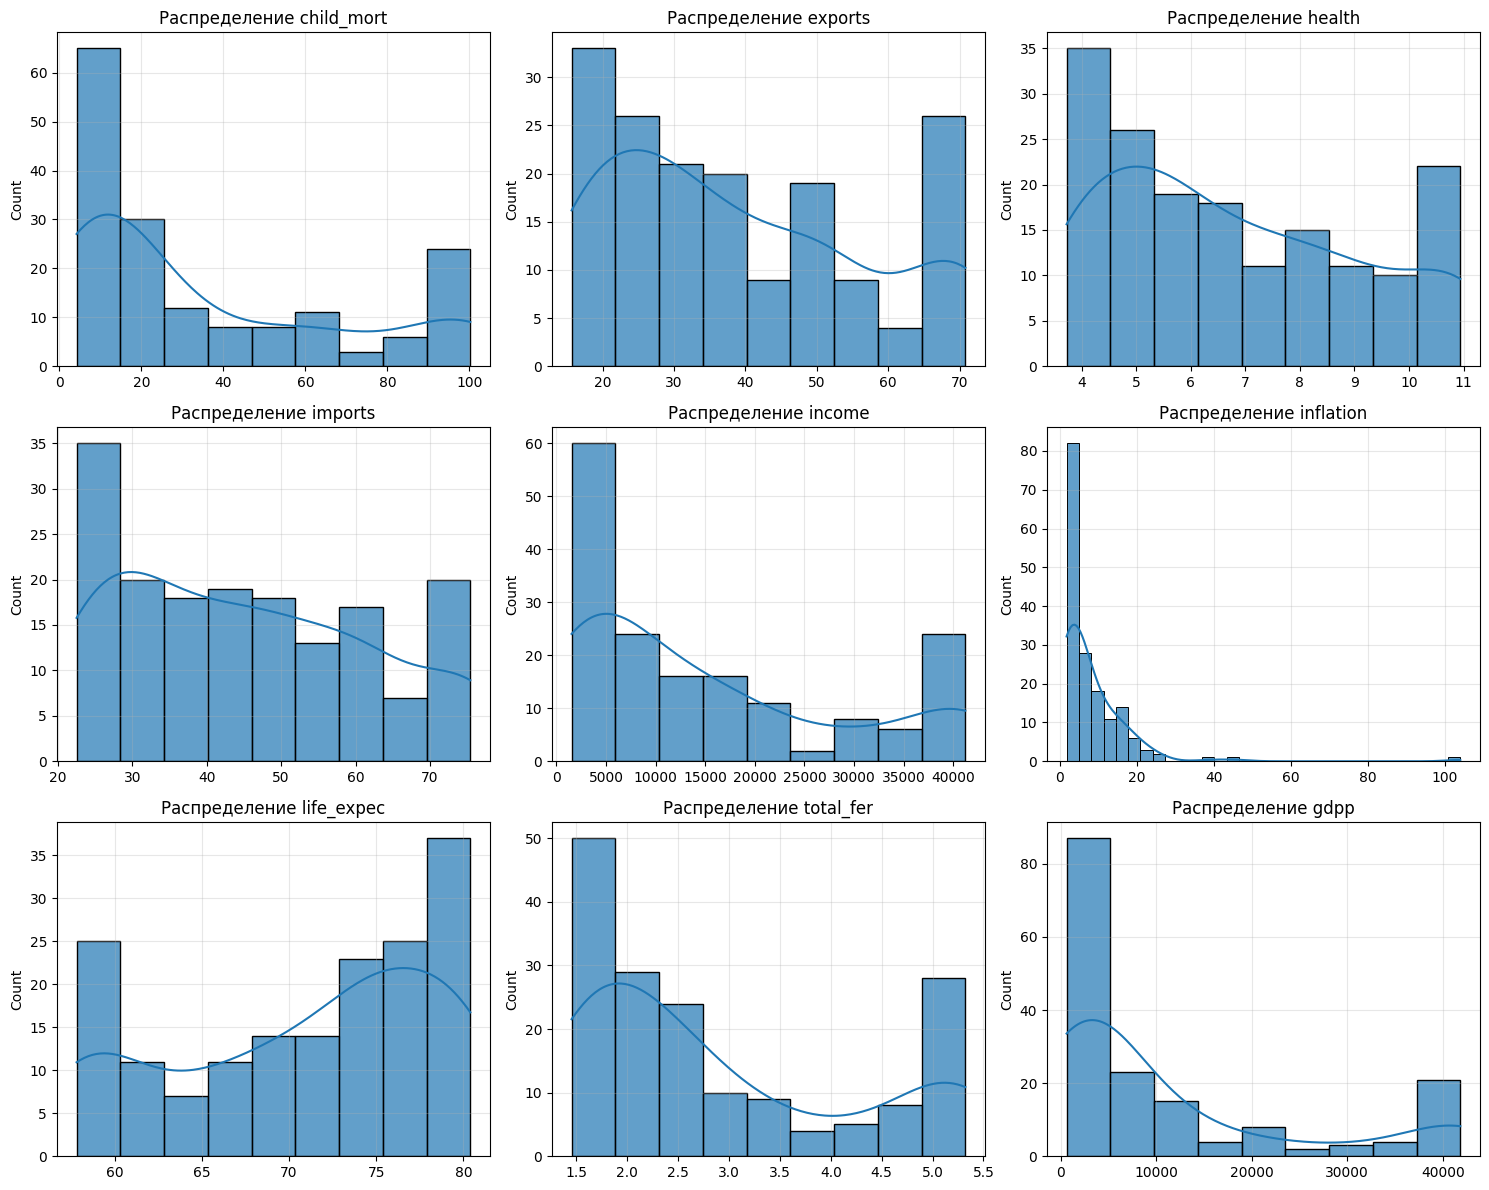

In [ ]:
num_cols = df_w.select_dtypes(include=[np.number]).columns
n_features = len(num_cols)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df_w[col], ax=axes[i], kde=True, alpha=0.7)
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel('')
    axes[i].grid(True, alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


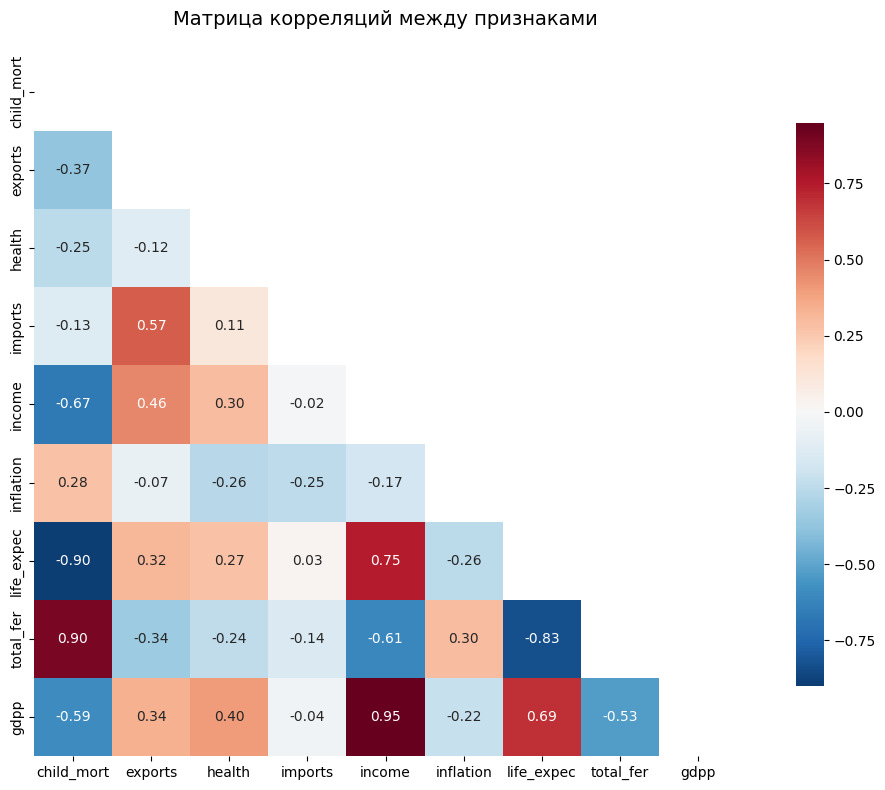

Сильные корреляции:
  child_mort ↔ life_expec: -0.899
  child_mort ↔ total_fer: 0.897
  income ↔ life_expec: 0.745
  income ↔ gdpp: 0.948
  life_expec ↔ total_fer: -0.832


In [ ]:

corr_matrix = df_w[num_cols].corr()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций между признаками', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

strong_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            strong_corr.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if strong_corr:
    print("Сильные корреляции:")
    for feat1, feat2, corr in strong_corr:
        print(f"  {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("\nСильных корреляций нет")


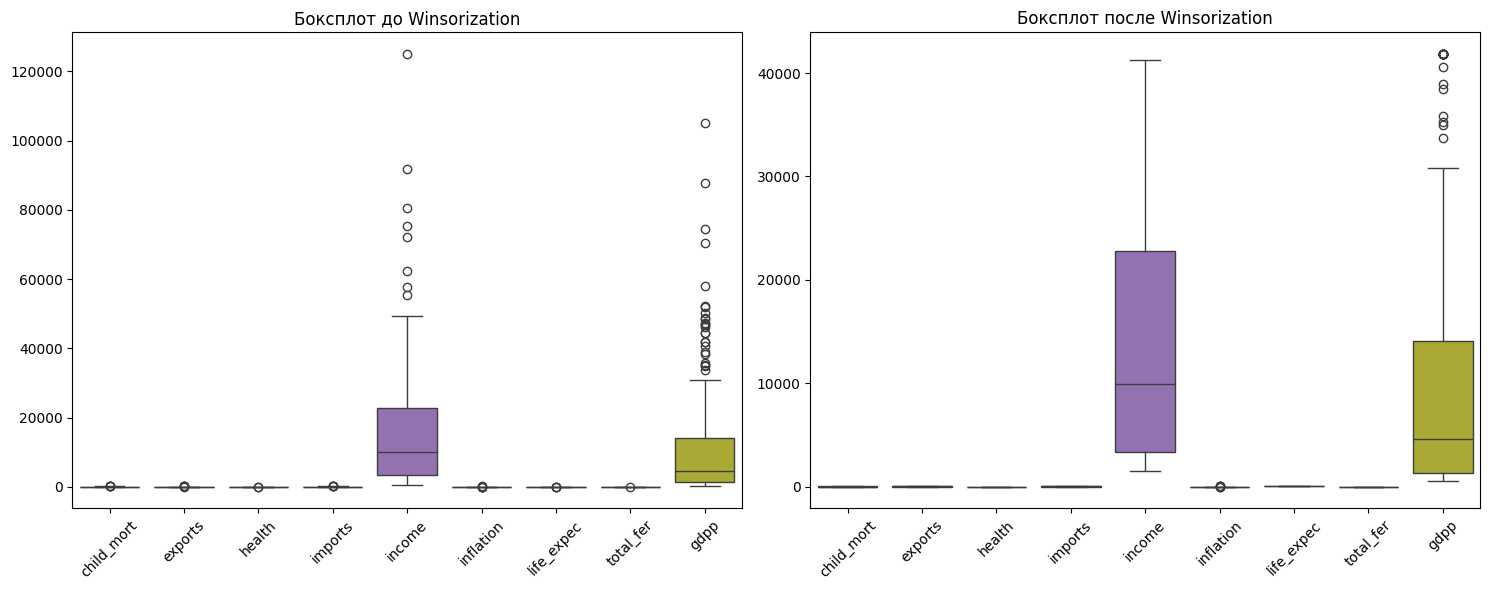

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=df[num_cols], ax=axes[0])
axes[0].set_title('Боксплот до Winsorization')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df_w[num_cols], ax=axes[1])
axes[1].set_title('Боксплот после Winsorization')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### Скалируем данные

In [ ]:
features = ['child_mort', 'exports', 'health', 'imports', 'income',
            'inflation', 'life_expec', 'total_fer', 'gdpp']

X = df_w[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaled_stats = pd.DataFrame(X_scaled, columns=features).describe()
print("Статистика после стандартизации:")
display(scaled_stats.round(3))



Статистика после стандартизации:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000,167.000,167.000,167.000,167.000,167.000,167.000,167.000,167.000
mean,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000
std,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003
min,-0.940,-1.284,-1.314,-1.343,-1.007,-0.612,-1.712,-1.062,-0.786
25%,-0.819,-0.833,-0.802,-0.889,-0.872,-0.612,-0.733,-0.808,-0.732
50%,-0.487,-0.213,-0.202,-0.114,-0.388,-0.265,0.287,-0.353,-0.492
75%,0.797,0.694,0.775,0.801,0.553,0.256,0.772,0.735,0.187
max,1.941,1.771,1.778,1.787,1.903,9.307,1.243,1.802,2.196



# Определяем оптимальное количество кластеров

# K-Means

In [ ]:
inertias, silhouettes = [], []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels_kmeans = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels_kmeans))

График локтя, силуэтов

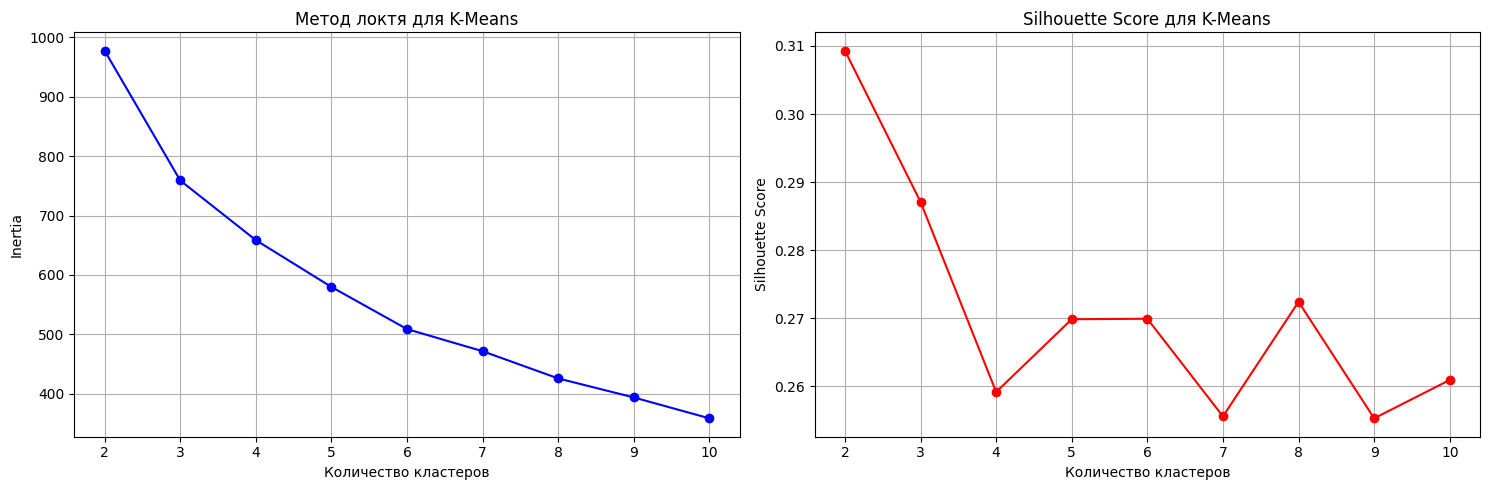

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Inertia')
ax1.set_title('Метод локтя для K-Means')
ax1.grid(True)

ax2.plot(k_range, silhouettes, 'ro-')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score для K-Means')
ax2.grid(True)

plt.tight_layout()
plt.show()


Выбираем оптимальное k


In [ ]:
optimal_k = k_range[np.argmax(silhouettes)]
print(f"Оптимальное количество кластеров: {optimal_k}")
print(f"Лучший silhouette score: {max(silhouettes):.3f}")

Оптимальное количество кластеров: 2
Лучший silhouette score: 0.309


Кластеризация с оптимальным k, также сравню с MiniBatch


In [ ]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
kmeans_labels = kmeans_final.fit_predict(X_scaled)
df_w['kmeans_cluster'] = kmeans_labels

minibatch_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, n_init=5, batch_size=100)
minibatch_labels = minibatch_kmeans.fit_predict(X_scaled)
df_w['minibatch_cluster'] = minibatch_labels

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
minibatch_silhouette = silhouette_score(X_scaled, minibatch_labels)

print(f"K-Means: {kmeans_silhouette:.3f}")
print(f"MiniBatch K-Means Silhouette Score: {minibatch_silhouette:.3f}")


K-Means: 0.309
MiniBatch K-Means Silhouette Score: 0.309



# Иерархическая кластеризация

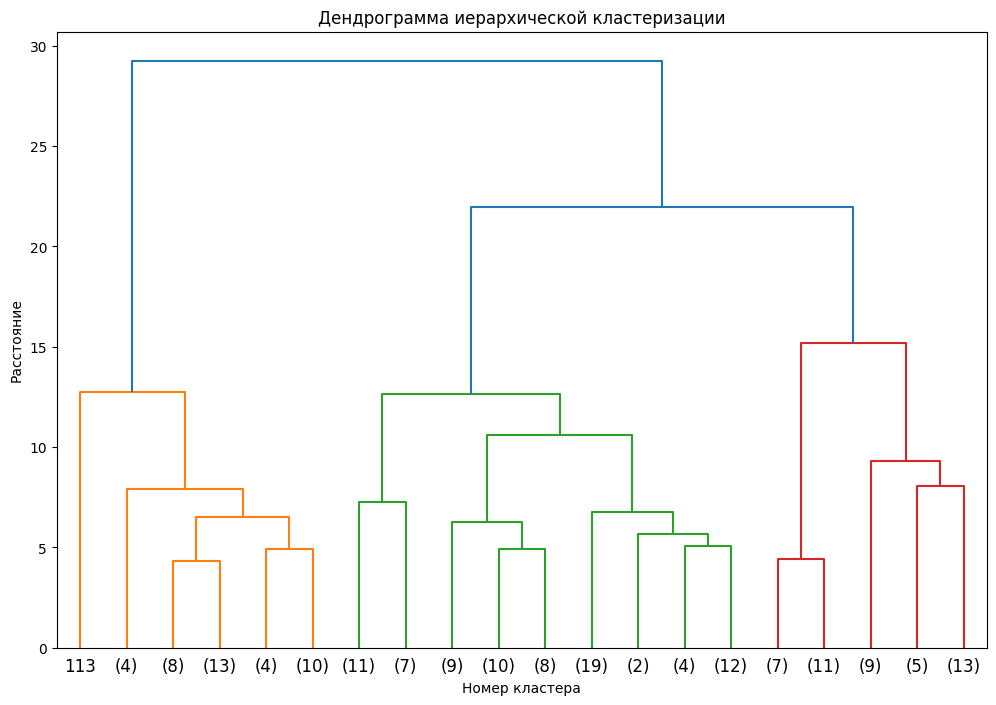

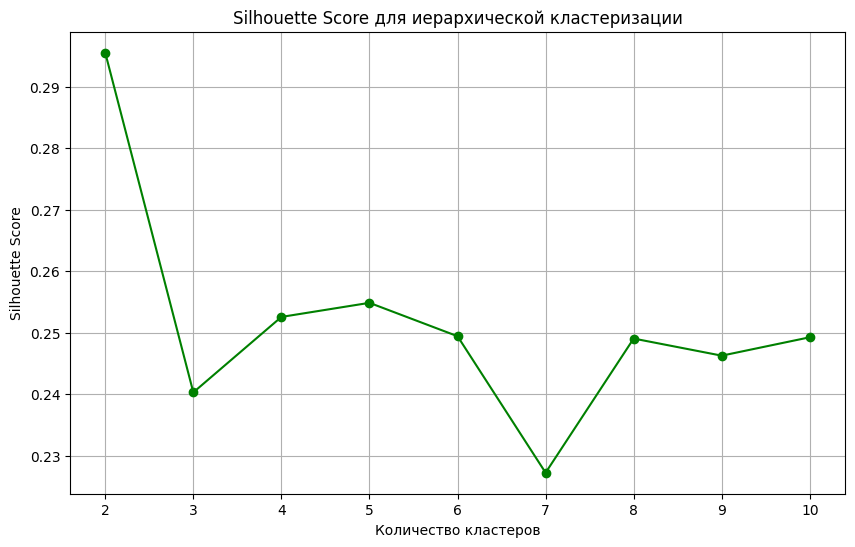

Оптимальное количество кластеров: 2
Лучший silhouette score: 0.296


In [ ]:
plt.figure(figsize=(12, 8))
Z = sch.linkage(X_scaled, method='ward')
sch.dendrogram(Z, truncate_mode='lastp', p=20, show_leaf_counts=True)
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Номер кластера')
plt.ylabel('Расстояние')
plt.show()

hierarchical_silhouettes = []
hierarchical_range = range(2, 11)

for k in hierarchical_range:
    hierarchical = AgglomerativeClustering(n_clusters=k)
    labels_hierarchical = hierarchical.fit_predict(X_scaled)
    hierarchical_silhouettes.append(silhouette_score(X_scaled, labels_hierarchical))

plt.figure(figsize=(10, 6))
plt.plot(hierarchical_range, hierarchical_silhouettes, 'go-')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score для иерархической кластеризации')
plt.grid(True)
plt.show()

optimal_hierarchical_k = hierarchical_range[np.argmax(hierarchical_silhouettes)]
print(f"Оптимальное количество кластеров: {optimal_hierarchical_k}")
print(f"Лучший silhouette score: {max(hierarchical_silhouettes):.3f}")

hierarchical_final = AgglomerativeClustering(n_clusters=optimal_hierarchical_k)
hierarchical_labels = hierarchical_final.fit_predict(X_scaled)
df_w['hierarchical_cluster'] = hierarchical_labels

# DBSCAN

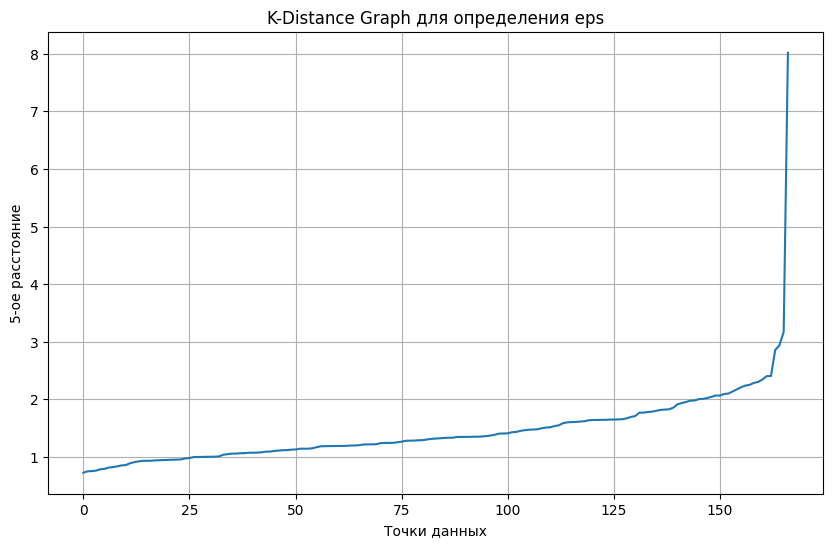

Количество кластеров: 1
Количество шумовых точек: 4
Процент шума: 2.40%


In [ ]:
k = 5
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Graph для определения eps')
plt.xlabel('Точки данных')
plt.ylabel(f'{k}-ое расстояние')
plt.grid(True)
plt.show()

kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
optimal_eps = distances[kneedle.knee] if kneedle.knee else 0.5

dbscan = DBSCAN(eps=optimal_eps, min_samples=k)
dbscan_labels = dbscan.fit_predict(X_scaled)
df_w['dbscan_cluster'] = dbscan_labels

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Количество кластеров: {n_clusters_dbscan}")
print(f"Количество шумовых точек: {n_noise}")
print(f"Процент шума: {n_noise/len(dbscan_labels)*100:.2f}%")


# Анализ результатов кластеризации


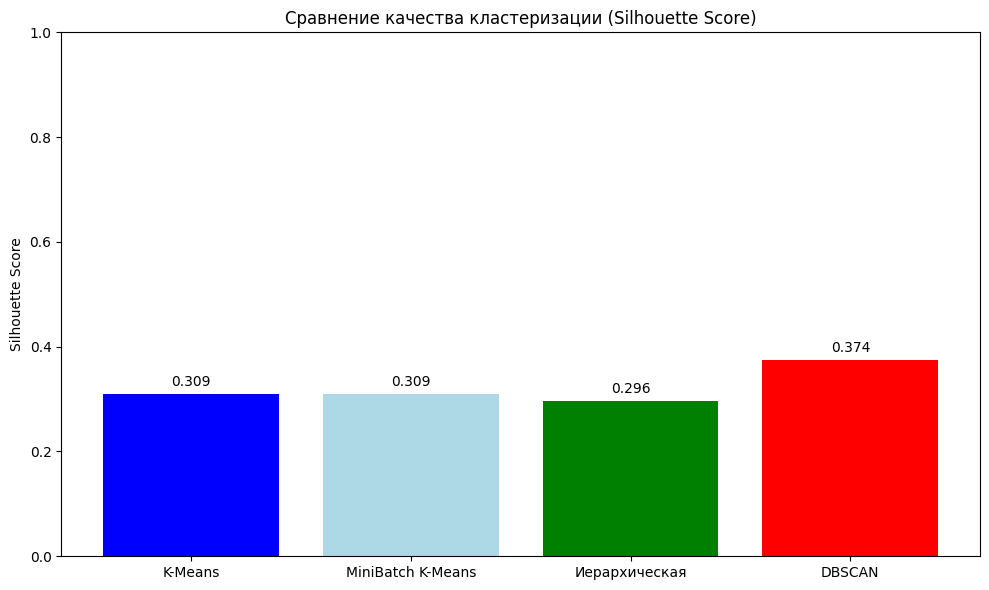

In [ ]:
cluster_stats = df_w.groupby('kmeans_cluster')[features].mean().round(2)
cluster_sizes = df_w['kmeans_cluster'].value_counts().sort_index()
methods = ['K-Means', 'MiniBatch K-Means', 'Иерархическая', 'DBSCAN']
labels_list = [kmeans_labels, minibatch_labels, hierarchical_labels, dbscan_labels]

silhouette_scores = []
for i, labels in enumerate(labels_list):
    if len(set(labels)) > 1:
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, silhouette_scores, color=['blue', 'lightblue', 'green', 'red'])
plt.title('Сравнение качества кластеризации (Silhouette Score)')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)

for bar, score in zip(bars, silhouette_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
cluster_stats_normalized = (cluster_stats - cluster_stats.mean()) / cluster_stats.std()

weights = {
    'child_mort': 1.0,
    'exports': -0.5,
    'health': -1.0,
    'imports': -0.3,
    'income': -1.0,
    'inflation': 0.7,
    'life_expec': -1.0,
    'total_fer': 0.8,
    'gdpp': -1.0
}

need_scores = {}
for cluster in cluster_stats.index:
    score = 0
    for feature, weight in weights.items():
        score += cluster_stats_normalized.loc[cluster, feature] * weight
    need_scores[cluster] = score

print("Оценки нуждаемости по кластерам:")
for cluster, score in sorted(need_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"Кластер {cluster}: {score:.2f}")

for cluster in sorted(df_w['kmeans_cluster'].unique()):
    cluster_data = df_w[df_w['kmeans_cluster'] == cluster]
    cluster_center = kmeans_final.cluster_centers_[cluster]

    distances = np.linalg.norm(X_scaled[df_w['kmeans_cluster'] == cluster] - cluster_center, axis=1)
    typical_country_idx = distances.argmin()
    typical_country = cluster_data.iloc[typical_country_idx]['country']

    print(f"\nКЛАСТЕР {cluster}")
    print("-----------------------")
    print(f"Количество стран: {len(cluster_data)}")
    print(f"Эталонная страна: {typical_country}")

    stats = cluster_stats.loc[cluster]
    print("Характеристики:")
    print(f"  - Детская смертность: {stats['child_mort']:.1f} (на 1000)")
    print(f"  - ВВП на душу: ${stats['gdpp']:.0f}")
    print(f"  - Доход: ${stats['income']:.0f}")
    print(f"  - Продолжительность жизни: {stats['life_expec']:.1f} лет")
    print(f"  - Фертильность: {stats['total_fer']:.1f} детей на женщину")
    print(f"  - Расходы на здравоохранение: {stats['health']:.1f}% ВВП")

    if stats['gdpp'] < 2000 and stats['child_mort'] > 50:
        cluster_type = "Развивающиеся страны с критической ситуацией"
        priority = "ВЫСОКИЙ ПРИОРИТЕТ"
    elif stats['gdpp'] < 5000:
        cluster_type = "Развивающиеся страны"
        priority = "СРЕДНИЙ ПРИОРИТЕТ"
    elif stats['gdpp'] < 15000:
        cluster_type = "Страны со средним доходом"
        priority = "НИЗКИЙ ПРИОРИТЕТ"
    else:
        cluster_type = "Развитые страны"
        priority = "МИНИМАЛЬНАЯ ПОМОЩЬ"

    print(f"Тип: {cluster_type}")
    print(f"Приоритет помощи: {priority}")

df_w['need_score'] = (
    df_w['child_mort'] / df_w['child_mort'].max() * 0.3 +
    (1 - df_w['gdpp'] / df_w['gdpp'].max()) * 0.3 +
    (1 - df_w['life_expec'] / df_w['life_expec'].max()) * 0.2 +
    df_w['total_fer'] / df_w['total_fer'].max() * 0.2
)

top_needy_countries = df_w.nlargest(10, 'need_score')[['country', 'child_mort', 'gdpp', 'life_expec', 'total_fer', 'need_score']]
print("\nТоп 10 нуждающихся:")
display(top_needy_countries.round(3))


Оценки нуждаемости по кластерам:
Кластер 1: 5.16
Кластер 0: -5.16

КЛАСТЕР 0
-----------------------
Количество стран: 99
Эталонная страна: Poland
Характеристики:
  - Детская смертность: 12.3 (на 1000)
  - ВВП на душу: $17945
  - Доход: $22764
  - Продолжительность жизни: 76.3 лет
  - Фертильность: 2.0 детей на женщину
  - Расходы на здравоохранение: 7.2% ВВП
Тип: Развитые страны
Приоритет помощи: МИНИМАЛЬНАЯ ПОМОЩЬ

КЛАСТЕР 1
-----------------------
Количество стран: 68
Эталонная страна: Ghana
Характеристики:
  - Детская смертность: 69.4 (на 1000)
  - ВВП на душу: $2016
  - Доход: $4326
  - Продолжительность жизни: 63.0 лет
  - Фертильность: 4.2 детей на женщину
  - Расходы на здравоохранение: 6.1% ВВП
Тип: Развивающиеся страны
Приоритет помощи: СРЕДНИЙ ПРИОРИТЕТ

Топ 10 нуждающихся:


,country,child_mort,gdpp,life_expec,total_fer,need_score
37,"Congo, Dem. Rep.",100.22,593.8,57.82,5.322,0.852
106,Mozambique,100.22,593.8,57.82,5.322,0.852
25,Burkina Faso,100.22,593.8,57.90,5.322,0.852
63,Guinea,100.22,648.0,58.00,5.322,0.851
32,Chad,100.22,897.0,57.82,5.322,0.850
112,Niger,100.22,593.8,58.80,5.322,0.849
31,Central African Republic,100.22,593.8,57.82,5.210,0.848
132,Sierra Leone,100.22,593.8,57.82,5.200,0.847
97,Mali,100.22,708.0,59.50,5.322,0.847
40,Cote d'Ivoire,100.22,1220.0,57.82,5.270,0.845


# Вывод

Выявлены страны, требующие помощи:

1. **Демократическая Республика Конго** - лидер по нуждаемости
2. **Мозамбик** - сопоставимые с Конго показатели
3. **Буркина-Фасо** - критическая ситуация в Западной Африке
4. **Гвинея** - высокие риски социального коллапса
5. **Чад** - экстремальная бедность
6. **Нигер** - демографические проблемы
7. **ЦАР** - политическая нестабильность усугубляет положение
8. **Сьерра-Леоне** - последствия гражданской войны
9. **Мали** - проблемы безопасности и развития
10. **Кот-д'Ивуар** - тоже не особо супер все


### Что заметила:
- **Четкая биполярность** мирового развития требует дифференцированного подхода
- **Кластер 1** сосредоточен преимущественно в Африке южнее Сахары


